In [320]:
import pandas as pd
import numpy as np
import re
import pickle
import string

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import jaccard_score


import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


# Loading in data about Bay Area elections

In [3]:
df = pd.read_excel('csv-voter-nominated-candidates.xls')

In [4]:
sf_df = df[df['COUNTY_NAME'] == 'San Francisco']

In [5]:
mask_13th = sf_df.CONTEST_NAME != 'United States Representative District 13'
mask_14th = sf_df.CONTEST_NAME != 'United States Representative District 14'
mask_19th = sf_df.CONTEST_NAME != 'State Assembly Member District 19'

sf_df[mask_13th & mask_14th & mask_19th]

,ELECTION_DATE,ELECTION_NAME,COUNTY_ID,COUNTY_NAME,CONTEST_ID,CONTEST_NAME,CANDIDATE_ID,CANDIDATE_NAME,INCUMBENT_FLAG,WRITE_IN_FLAG,PARTY_ID,PARTY_NAME,VOTE_TOTAL
831,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,571,Nancy Pelosi,Y,N,1,Democratic,190590
832,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,866,Agatha Bacelar,N,N,1,Democratic,3890
833,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,867,Shahid Buttar,N,N,1,Democratic,33344
834,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,869,John Dennis,N,N,3,Republican,19883
835,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,873,Tom Gallagher,N,N,1,Democratic,5094
836,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,879,Deanna Lorraine,N,N,3,Republican,4635
843,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,120000110000,State Senate District 11,533,Scott Wiener,Y,N,1,Democratic,154001
844,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,120000110000,State Senate District 11,831,Jackie Fielder,N,N,1,Democratic,92141
845,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,120000110000,State Senate District 11,832,Erin Smith,N,N,3,Republican,29285
846,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,130000170000,State Assembly Member District 17,617,David Chiu,Y,N,1,Democratic,120498


Ok the plan is to scrape the twitter feeds for all of these people and then perform NLP on the resulting data. First let's test the NLP pipeline with Nancy Pelosi's tweets

In [6]:
pelosi_tweets = pd.read_csv('SpeakerPelosi_03_2019_to_03_2020.csv')

# Preprocessing pipeline

In [13]:
#lemmatization function taken from Selva Prabhakaran's post on Machine Learning Plus
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [14]:
def text_clean(data):
    """
    Purpose: Takes tweets in a dataframe, cleans each tweet and returns an array with cleaned tweets.
    Arguments: dataframe of tweets for a column called "text" containing the text of the tweet
    Returns: cleaned array of tweets
    """
    
    df = data.text.drop_duplicates()
    
    #taking our URLs
    urls = lambda x: re.sub(r'http\S+', '' ,str(x))

    #taking out capitalization and digits
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', str(x))

    #removing punctuation
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', str(x).lower())
    
    #applies the above three functions on the data
    df = df.map(urls).map(alphanumeric).map(punc_lower)
    
    #turn data into a list of tweets
    data_list = [x for x in df]
    
    #initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    #lemmatize the words
    data = []
    for sentence in data_list:
        data.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])
    
    #combine the words back into tweets
    final = []
    for sentence in data:
        final.append(' '.join(sentence))
    
    return final
    

In [15]:
#function taken from lecture slides to help display the topics and the top words per topic
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [16]:
result = text_clean(pelosi_tweets)
result

['every time an american be force to ration medication or not fill a prescription it s a failure of senate republican the house have vote to allow hhs to negotiate for lowerdrugcosts how long do family have to wait for senatemajldr to do the same',
 'the aca be a pillar of health economic security for american family — and even more critical during an epidemic but in the middle of the coronavirus crisis the trump admin continue to ask the court to tear health coverage away from million',
 'cautiously optimistic about u s taliban agreement for condition base troop drawdown many significant additional step remain to achieve comprehensive and endure peace afghan woman must be at the negotiate table their voice must be heard',
 'womenshistorymonth reminds u that when woman succeed america succeed',
 'congress be take step to ensure the government have access to the resource need to combat this deadly virus keep american safe house appropriator be work hard on a funding package which we hop

In [17]:
#adding custom stop words for this use case
addl_stop_words = ['live', 'today', 'must', 'join', 'campaign', 'reporter', 'tune', 'pm', 'et', 'press','weekly',
                  'year','thank', 'thanks', 'support', 'appreciate', 'rsvp', 'say', 'get', 'amp']

custom_stop_words = stopwords.words('english') + addl_stop_words

# Testing out data manipulation

# Assembling the vectors with words as features

In [481]:
def create_sentiment_vectors(list_of_tweets,handle,word=None):
    """
    Purpose: Get total positive, neutral, negative and compound sentiment scores for each tweet and then return the sum
    of all those scores in a single vector for each politician
    Arguments: List of tweets
    Returns: One row dataframe with total sentiment scores for that politician
    """
    
    #Initializing variables
    neg = 0
    neu = 0
    pos = 0 
    compound = 0
    
    #initializing sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    #performing sentiment analysis on a tweet by tweet basis
    for val in list_of_tweets:
        sentiment_dict = analyzer.polarity_scores(val)
        neg += sentiment_dict['neg']
        neu += sentiment_dict['neu']
        pos += sentiment_dict['pos']
        compound += sentiment_dict['compound']
    
    #conditional logic that will change behavior based on if this sentiment vector is only for one word or the whole df
    if word is not None:
        final = pd.DataFrame([[neg,neu,pos,compound]], index=[handle],
                             columns= [word + '_' + val for val in sentiment_dict.keys()])
    else:
        final = pd.DataFrame([[neg,neu,pos,compound]], index=[handle], columns= sentiment_dict.keys())
        
    return final

In [506]:
def get_politician_vectors(twitter_handle,top_words=False,top_words_amount=50,neu=False,neg=False,pos=False,compound=False):
    """
    Purpose: Take politician tweets from last year and turn it vector of words 
    Arguments: Twitter handle in string
    Returns: Dataframe with vector
    """

    #adding custom stop words for this use case
    addl_stop_words = ['live', 'today', 'must', 'join', 'campaign', 'reporter', 'tune', 'pm', 'et', 'press','weekly',
                  'year','thank', 'thanks', 'support', 'appreciate', 'rsvp', 'say', 'get', 'amp']

    custom_stop_words = stopwords.words('english') + addl_stop_words
    
    #load in data
    file = 'data/' + twitter_handle + '_03_2019_to_03_2020.csv'
    df = pd.read_csv(file)
    
    #clean the data
    result = text_clean(df)
    number_of_tweets = len(result)
    
    #this is commented out because no
    #sentiment = create_sentiment_vectors(result,twitter_handle)
    
    #create the document-term matrix
    tfidf = TfidfVectorizer(stop_words=custom_stop_words,ngram_range=(1,3), min_df = 5, max_df=.9, binary=True)
    doc_word = tfidf.fit_transform(result)
    doc_word_df = pd.DataFrame(doc_word.toarray(),index=df.text.drop_duplicates(),columns=tfidf.get_feature_names())
    
    #sum up all columns
    data = np.zeros((1,len(doc_word_df.columns)))
    for i,column in enumerate(doc_word_df.columns):
        data[0,i] = doc_word_df[column].sum()
    
    #put the sums into a new dataframe
    final = pd.DataFrame(data,index=[twitter_handle], columns=doc_word_df.columns)
        
    #get sentiment for top words 
    if top_words == True:
        top_words = list(final.T.sort_values(by=twitter_handle,ascending=False).index[0:top_words_amount])
        for word in top_words:
            mini_df = pd.DataFrame(result,columns=['text'])
            tweets_for_this_word = mini_df[mini_df.text.str.contains(word)].text.to_list()
            if len(tweets_for_this_word) != 0:
                senti_df = create_sentiment_vectors(tweets_for_this_word,twitter_handle,word)
                for column in senti_df.columns:
                    final[column] = senti_df.at[twitter_handle,column]

    return final,number_of_tweets

In [505]:
#using the above funciton in some code to organize all poltician vectors into one dataframe

twitter_handles = ['AgathaBacelar', 'DavidChiu', 'DeAnna4Congress', 'erinsmithSF', 'JackieFielder_',
                  'RealJohnDennis', 'Scott_Wiener', 'ShahidForChange', 'SpeakerPelosi', 'TomGallagherSF']

for i,handle in enumerate(twitter_handles):
    df = get_politician_vectors(handle,top_words=True,top_words_amount=200)
    if i > 0:
        big_df = pd.concat([big_df, df], axis=0)
    else:
        big_df = df
    print(str(i) + ' completed!')

big_df

0 completed!


TypeError: cannot concatenate object of type '<class 'tuple'>'; only Series and DataFrame objs are valid

# Visualizing the Vectors

In [485]:
tryit = big_df.fillna(0)

In [486]:
tryit

,able,absolutely,access,accord,across,act,action,actually,actually increase,additional,...,hustings,nowaroniran,petition via,petition via change,sign petition via,syria,tom gallagher,tomfromthehustings,turkey,via change
AgathaBacelar,1.592918,5.899866,1.543891,1.988780,3.936818,3.398603,5.717011,3.148711,1.894575,1.743352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DavidChiu,4.632526,0.000000,3.902950,0.000000,3.742977,3.083046,3.434456,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DeAnna4Congress,7.367748,6.589602,0.000000,0.000000,1.541946,7.325702,4.442053,20.807721,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
erinsmithSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JackieFielder_,0.000000,0.000000,0.000000,0.000000,0.000000,3.451876,0.000000,2.396331,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RealJohnDennis,0.000000,2.463268,0.000000,0.000000,2.015004,0.000000,3.312497,2.992200,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Scott_Wiener,5.285572,1.877253,10.881592,4.186577,0.000000,9.415104,6.759160,4.247445,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ShahidForChange,2.254856,4.232785,4.146175,0.000000,19.954791,11.461734,21.781062,3.290216,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SpeakerPelosi,2.793834,0.000000,4.518422,0.000000,12.151418,23.425634,12.008834,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TomGallagherSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.368171,2.360259,1.446806,1.446806,1.446806,2.303337,1.797225,3.590902,2.235428,1.741171


### 2D

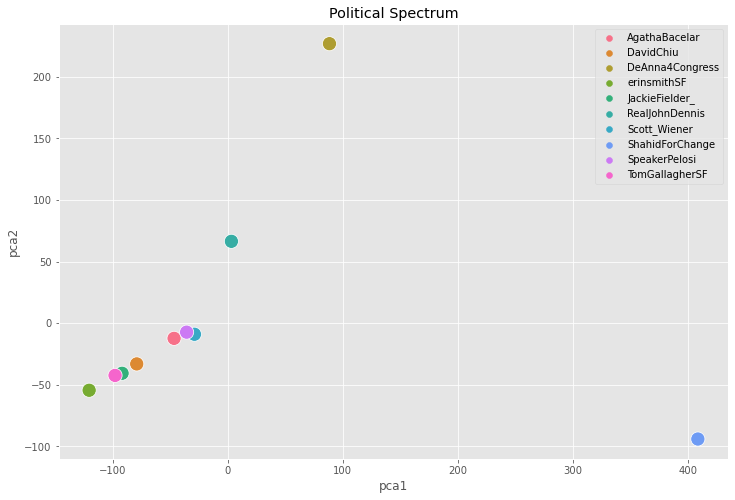

In [487]:
reduced_data = PCA(n_components=2).fit_transform(tryit)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

plt.figure(figsize=(12,8))
sns.scatterplot(x="pca1", y="pca2", s=200,hue=tryit.index, data=results)
plt.title('Political Spectrum')
plt.show()

In [408]:
results.set_index(tryit.index)
#results.set_index(tryit.index).to_pickle('2D_PCA_table.pkl')

,pca1,pca2
AgathaBacelar,-553.866226,-86.766922
DavidChiu,-515.040358,-323.636876
DeAnna4Congress,-204.478505,1109.938968
erinsmithSF,-738.512003,-293.250822
JackieFielder_,-605.872406,-282.707847
RealJohnDennis,-256.838193,541.982804
Scott_Wiener,-218.200105,-394.028206
ShahidForChange,4257.122436,-103.609310
SpeakerPelosi,-523.879692,95.410778
TomGallagherSF,-640.434948,-263.332568


Yes it worked! Generally, it seemed like the results are pretty accurate too! The far left guy (Shahid) and far right woman (DeAnna) are both separated from the pack. John Dennis, the other big republican is also separated from the pack and towards the direction of DeAnna but not as far. Also, Nancy Pelosi is very close to center. 

**Next Steps:**
1. Build recommender system (MVP)
    1. Find a way to map voters who answer project 3 dataset questions onto this graph
    1. Add someone's twitter feed to this dataset as a test to see if it will place them correctly
    1. Compare if answering some questions or if scraping twitter will better at estimating where someone lies on the political spectrum
    1. The recommendation system should recommend 1 of each type of politician (e.g. 1 state senator, 1 state assembly 
    man/woman...)
1. Figure out how to expand this to every district in San Francisco
1. Figure out how to make a super cool web app that gives recommendations to people about who they should vote for, tells them why they model picked those people, and shows where the voter lies on the political spectrum


More notes:
* Upon second glance, there are some progressive democratic candidates that are getting plotted close to Pelosi. 
* This works better with words rather than topics because if you use topics the plotting becomes way more manual. Probably more accurate with Topics though??
* Tried to see if 3D plotting seperates the candidates more. It's hard to say really. The one big difference is that Scott Weiner and Nancy Pelosi are now also separated from "the pack". They form almost this moderate grouping. Otherwise everything else is the same. Deanna, John, and Shahid are all separated from the pack. And everyone else is close together.


In [84]:
#tryit.to_pickle('politician vecotr.pkl')

### 3D

In [382]:
reduced_data_3d = PCA(n_components=3).fit_transform(tryit)
results_3d = pd.DataFrame(reduced_data_3d,columns=['pca1','pca2', 'pca3'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

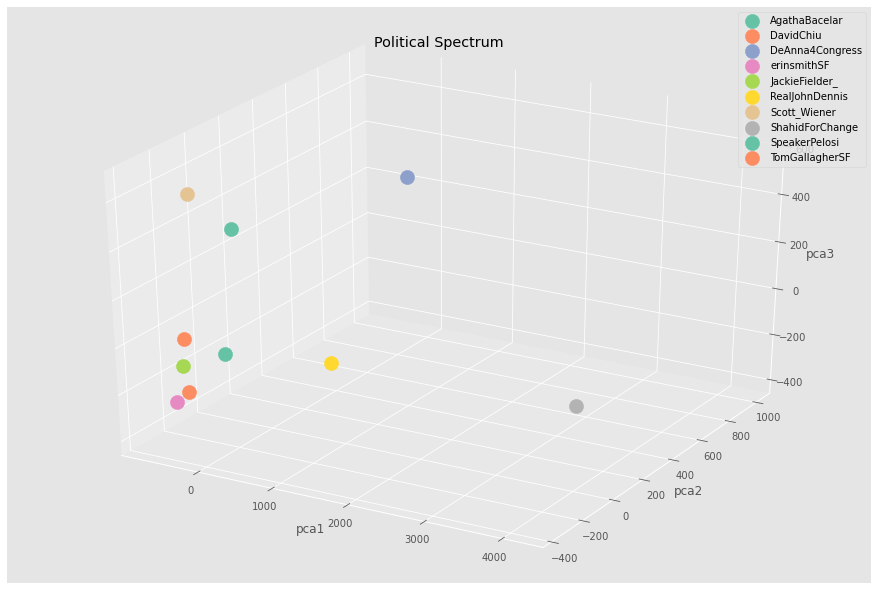

In [383]:
fig = plt.figure(figsize=(12,8))

ax = Axes3D(fig) 

color=sns.color_palette("Set2", n_colors=10)
for i,row in enumerate(results_3d.values):
    x=row[0]
    y=row[1]
    z=row[2]
    ax.scatter(x, y, z, c=color[i], s=200, marker='o', label=tryit.index[i])

ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.legend()

plt.title('Political Spectrum')
plt.show()

In [87]:
results_3d.set_index(tryit.index)

,pca1,pca2,pca3
AgathaBacelar,-346.096589,-4.349424,3.473148
DavidChiu,-653.285210,-20.233809,-14.641778
DeAnna4Congress,1357.465815,218.457520,-10.738605
erinsmithSF,-1123.769778,-41.947630,19.994474
JackieFielder_,-768.777119,-26.872975,3.209232
RealJohnDennis,92.013784,57.139701,123.960165
Scott_Wiener,8.934278,9.954333,-79.139285
ShahidForChange,2356.534074,-172.540415,11.965667
SpeakerPelosi,-107.530537,8.743553,-77.846538
TomGallagherSF,-815.488718,-28.350853,19.763519


# Testing distances

In [507]:
def create_similarity_matrix(similarity_tool,df_vectors):
    """
    Purpose: Take a dataframe with vectors of politicians and output a matrix showing similarity between them
    Arguments: similarity_tool: cosine similarity or euclidean distance, a dataframe with vectors
    Returns: a brand new dataframe with similarity scores
    """
    
    similarities = []
    
    iters = len(df_vectors.index)
    for i in range(iters):
        first_vec = df_vectors.iloc[i,:].values.reshape(1,-1)
        similarities.append([])
        for j in range(iters):
            second_vec = df_vectors.iloc[j,:].values.reshape(1,-1)
            similarities[i].append(similarity_tool(first_vec,second_vec)[0][0])
    
                
    df = pd.DataFrame(similarities, index=df_vectors.index, columns = df_vectors.index)      
    
    return df

In [489]:
create_similarity_matrix(cosine_similarity,tryit)

,AgathaBacelar,DavidChiu,DeAnna4Congress,erinsmithSF,JackieFielder_,RealJohnDennis,Scott_Wiener,ShahidForChange,SpeakerPelosi,TomGallagherSF
AgathaBacelar,1.000000,0.558723,0.629461,0.122453,0.559777,0.544937,0.589016,0.566225,0.472682,0.476339
DavidChiu,0.558723,1.000000,0.513373,0.058576,0.608771,0.414688,0.706575,0.461010,0.511224,0.350239
DeAnna4Congress,0.629461,0.513373,1.000000,0.108648,0.491092,0.670326,0.540163,0.534576,0.517966,0.453862
erinsmithSF,0.122453,0.058576,0.108648,1.000000,0.098404,0.102707,0.045518,0.067212,0.022073,0.067649
JackieFielder_,0.559777,0.608771,0.491092,0.098404,1.000000,0.403476,0.619545,0.452511,0.397041,0.388505
RealJohnDennis,0.544937,0.414688,0.670326,0.102707,0.403476,1.000000,0.428048,0.513373,0.396840,0.446491
Scott_Wiener,0.589016,0.706575,0.540163,0.045518,0.619545,0.428048,1.000000,0.498412,0.516237,0.346936
ShahidForChange,0.566225,0.461010,0.534576,0.067212,0.452511,0.513373,0.498412,1.000000,0.464397,0.420053
SpeakerPelosi,0.472682,0.511224,0.517966,0.022073,0.397041,0.396840,0.516237,0.464397,1.000000,0.337636
TomGallagherSF,0.476339,0.350239,0.453862,0.067649,0.388505,0.446491,0.346936,0.420053,0.337636,1.000000


In [490]:
heyo = create_similarity_matrix(cosine_similarity,tryit)
for column in heyo:
    print('The closest person to ' + str(column) + ' is ' + str(heyo[column].sort_values(ascending=False).index[1]))

The closest person to AgathaBacelar is DeAnna4Congress
The closest person to DavidChiu is Scott_Wiener
The closest person to DeAnna4Congress is RealJohnDennis
The closest person to erinsmithSF is AgathaBacelar
The closest person to JackieFielder_ is Scott_Wiener
The closest person to RealJohnDennis is DeAnna4Congress
The closest person to Scott_Wiener is DavidChiu
The closest person to ShahidForChange is AgathaBacelar
The closest person to SpeakerPelosi is DeAnna4Congress
The closest person to TomGallagherSF is AgathaBacelar


In [491]:
create_similarity_matrix(euclidean_distances,tryit)

,AgathaBacelar,DavidChiu,DeAnna4Congress,erinsmithSF,JackieFielder_,RealJohnDennis,Scott_Wiener,ShahidForChange,SpeakerPelosi,TomGallagherSF
AgathaBacelar,0.000003,114.089120,290.604244,134.123922,111.742618,194.259353,160.401675,469.787962,174.774396,118.627170
DavidChiu,114.089120,0.000005,316.760666,98.442586,78.766690,210.635293,145.333573,495.065090,164.988839,94.962033
DeAnna4Congress,290.604244,316.760666,0.000022,355.362633,327.482912,264.175238,299.527693,455.798384,304.508484,334.011663
erinsmithSF,134.123922,98.442586,355.362633,0.000000,68.889221,230.998638,196.996274,532.417225,191.924716,56.484119
JackieFielder_,111.742618,78.766690,327.482912,68.889221,0.000000,213.159066,163.570301,505.198771,176.329935,70.349755
RealJohnDennis,194.259353,210.635293,264.175238,230.998638,213.159066,0.000011,231.036556,459.098518,234.861408,212.315656
Scott_Wiener,160.401675,145.333573,299.527693,196.996274,163.570301,231.036556,0.000000,466.876481,191.433327,185.290794
ShahidForChange,469.787962,495.065090,455.798384,532.417225,505.198771,459.098518,466.876481,0.000031,475.044872,511.539721
SpeakerPelosi,174.774396,164.988839,304.508484,191.924716,176.329935,234.861408,191.433327,475.044872,0.000000,180.883500
TomGallagherSF,118.627170,94.962033,334.011663,56.484119,70.349755,212.315656,185.290794,511.539721,180.883500,0.000002


In [492]:
ok = create_similarity_matrix(euclidean_distances,tryit)
for column in ok:
    print('The closest person to ' + str(column) + ' is ' + str(ok[column].sort_values().index[1]))

The closest person to AgathaBacelar is JackieFielder_
The closest person to DavidChiu is JackieFielder_
The closest person to DeAnna4Congress is RealJohnDennis
The closest person to erinsmithSF is TomGallagherSF
The closest person to JackieFielder_ is erinsmithSF
The closest person to RealJohnDennis is AgathaBacelar
The closest person to Scott_Wiener is DavidChiu
The closest person to ShahidForChange is DeAnna4Congress
The closest person to SpeakerPelosi is DavidChiu
The closest person to TomGallagherSF is erinsmithSF


In [493]:
#heyo.to_pickle('cosine_similarity_matrix.pkl')
#ok.to_pickle('euclidean_distances_matrix.pkl')

In [494]:
def recommend(twitter_handle,similarity_tool):
    df = get_politician_vectors(twitter_handle)#,neu=True,neg=True,pos=True,compound=True)
    new_df = pd.concat([big_df, df], axis=0)
    new_df = new_df.fillna(0)
    sim_df = create_similarity_matrix(similarity_tool,new_df)
    if similarity_tool == cosine_similarity:
        return sim_df[twitter_handle].sort_values(ascending=False)
    if similarity_tool == euclidean_distances:
        return sim_df[twitter_handle].sort_values()

In [495]:
recommend('realDonaldTrump',cosine_similarity)

realDonaldTrump    1.000000
DeAnna4Congress    0.644695
SpeakerPelosi      0.549180
AgathaBacelar      0.529183
Scott_Wiener       0.518373
RealJohnDennis     0.512108
DavidChiu          0.480413
ShahidForChange    0.467839
TomGallagherSF     0.403414
JackieFielder_     0.402447
erinsmithSF        0.081497
Name: realDonaldTrump, dtype: float64

In [496]:
recommend('BernieSanders',cosine_similarity)

BernieSanders      1.000000
SpeakerPelosi      0.600750
AgathaBacelar      0.571860
Scott_Wiener       0.563958
DeAnna4Congress    0.547502
DavidChiu          0.525081
JackieFielder_     0.512865
ShahidForChange    0.505932
TomGallagherSF     0.434702
RealJohnDennis     0.401768
erinsmithSF        0.069345
Name: BernieSanders, dtype: float64

In [497]:
recommend('JoeBiden',cosine_similarity)

JoeBiden           1.000000
SpeakerPelosi      0.674688
DeAnna4Congress    0.580224
Scott_Wiener       0.550724
AgathaBacelar      0.527662
DavidChiu          0.516173
ShahidForChange    0.479662
JackieFielder_     0.446926
RealJohnDennis     0.418608
TomGallagherSF     0.388376
erinsmithSF        0.076913
Name: JoeBiden, dtype: float64

In [498]:
recommend('AOC',cosine_similarity)

AOC                1.000000
AgathaBacelar      0.677537
DeAnna4Congress    0.667201
Scott_Wiener       0.641129
SpeakerPelosi      0.618900
DavidChiu          0.588130
ShahidForChange    0.575585
JackieFielder_     0.566817
RealJohnDennis     0.502830
TomGallagherSF     0.469123
erinsmithSF        0.121163
Name: AOC, dtype: float64

Hmm hard to say which similarity metric is better. Erin Smith has weird Tweets so not including her results both metrics have 2 "egregrious" errors where we are saying a republican is most similar to a democrat (or vice versa) when we know thats not true. 

I think I need to experiment with sentiment analysis more to see how it can help.